In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer



In [25]:
def qpu_plot(qubit_list,num_nodes,gate_pos,gate_final_pos):
    num_qubits = len(qubit_list)
    qubits_per_node = num_qubits//num_nodes
    delta = 0.12
    for i_n in range(num_nodes):
        plt.fill_between([gate_pos-step,gate_final_pos],[(i_n-delta)*qubits_per_node,(i_n-delta)*qubits_per_node],[(i_n+1+delta)*qubits_per_node-1,(i_n+1+delta)*qubits_per_node-1],color="gainsboro")

    for i_q, qubit in enumerate(qubit_list):
        if i_q % 2 ==0:
            plt.plot([gate_pos-step,gate_final_pos],[i_q,i_q],"k")
        else:
            plt.plot([gate_pos-step,gate_final_pos],[i_q,i_q],color="gray")
        plt.text(-1.8,i_q-0.3, qubit, fontsize=10)

def circuit_plot(gate_pos,gate_seq):
    # gate_pos = 0
    # gate_final_pos = gate_pos+ (1+num_gates)*step
    for gate in gate_seq:
        g0 = int(gate[0].split(",")[-1])+ int(gate[0].split(",")[0])* qubits_per_node
        g1 = int(gate[1].split(",")[-1])+ int(gate[1].split(",")[0])* qubits_per_node
        plt.plot([gate_pos,gate_pos],[g0,g1],"k-")
        plt.plot(gate_pos,g0,"ko-",markersize=2.5)
        plt.plot([gate_pos],[g1],"ko-",markersize=6,markerfacecolor="white")
        plt.plot([gate_pos],[g1],"k+",markersize=6,markerfacecolor="white")
        gate_pos += step

    # plt.axis("off")
    # plt.show()
        

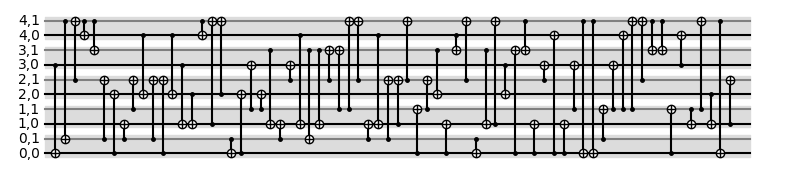

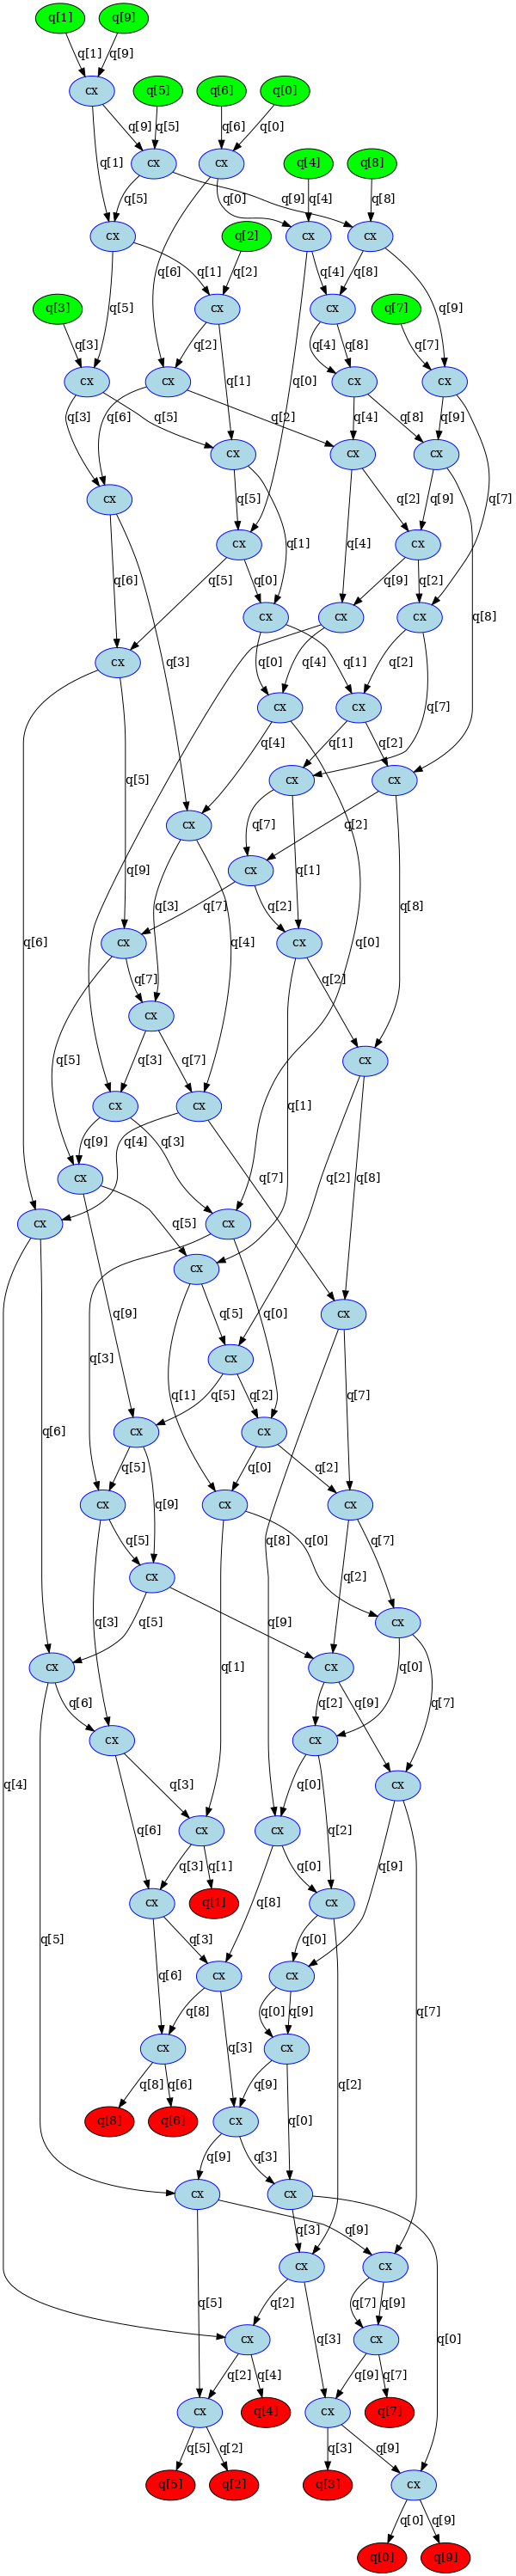

In [26]:
node_list = range(5)
qubits_per_node = 2
num_nodes = len(node_list)
num_qubits = num_nodes * qubits_per_node
num_gates = 70

# Q = nx.Graph()
# Q.add_nodes_from(node_list)

qubit_list = []
for node in node_list:
    for qubit in range(qubits_per_node):
        qubit_list.append((f"{node},{qubit}"))

connections = []
for i in range(num_qubits):
    for j in range(i+1,num_qubits):
        if np.random.rand() > 0.5:
            connections.append((qubit_list[i],qubit_list[j]))
        else:
            connections.append((qubit_list[j],qubit_list[i]))

# print(qubit_list)
gate_seq = random.choices(connections, k=num_gates)

# gate_seq = []
# for target in range(num_qubits-1,0,-1):
#     for control in range(target-1,-1,-1):
#         gate_seq.append((qubit_list[control],qubit_list[target]))
# print(gate_seq)

gate_pos = .1
step = .5
gate_final_pos = gate_pos+ (1+num_gates)*step
plt.figure(figsize=(10,2))
qpu_plot(qubit_list,num_nodes,gate_pos,1*gate_final_pos)
circuit_plot(gate_pos,gate_seq)
plt.axis("off")
plt.show()

qubit_nx_to_qiskit = {qubit: idx for idx, qubit in enumerate(qubit_list)}
qiskit_q_list = QuantumRegister(num_qubits, "q")
circ = QuantumCircuit(qiskit_q_list)

for g in gate_seq:
    circ.cx(qubit_nx_to_qiskit[g[0]], qubit_nx_to_qiskit[g[1]])
# print(circ)

dag = circuit_to_dag(circ)
dag_drawer(dag)

Include internal gates and remove them

In [22]:
def parallel_circuit_gen(node_list, qubits_per_node, num_gates):
    num_nodes = len(node_list)
    # node_list = range(num_nodes)
    # qubits_per_node = 3
    qubit_list = range(qubits_per_node)
    # num_qubits = num_nodes * qubits_per_node
    # num_gates = 30

    node_qubit_list = []
    for node in node_list:
        for qubit in range(qubits_per_node):
            node_qubit_list.append((f"{node},{qubit}"))

    connections = []
    for i in range(num_nodes):
        for j in range(i+1,num_nodes):
            connections.append((node_list[i],node_list[j]))

    gate_seq_nodes = random.choices(connections, k=num_gates)
    # print(gate_seq_nodes)
    gate_seq = []
    for n1, n2 in gate_seq_nodes:
        gate_seq.append((f"{n1},{random.sample(qubit_list,1)[0]}",f"{n2},{random.sample(qubit_list,1)[0]}"))

    gate_seq_iter = gate_seq.copy()

    Q = nx.Graph()
    Q.add_nodes_from(node_qubit_list)

    query_seq = []
    query = []
    gate_mul = {}
    gate_mul_seq = []
    while len(gate_seq_iter)>0:
        # print(gate_seq_iter)
        inds_keep = []
        not_block_gate = True
        for i_g, gate_nodes in enumerate(gate_seq_iter):
            if Q.degree[gate_nodes[0]] > 0 or Q.degree[gate_nodes[1]] > 0:
                if gate_nodes in query and not_block_gate:
                    gate_mul[gate_nodes] += 1
                    # query.append(gate_nodes)
                else:
                    Q.add_edge(gate_nodes[0],gate_nodes[1])
                    inds_keep.append(i_g)
                    not_block_gate = False
            else:
                Q.add_edge(gate_nodes[0],gate_nodes[1])
                query.append(gate_nodes)
                gate_mul[gate_nodes] =  1
                not_block_gate = True

        query_seq.append(query)
        gate_mul_seq.append(gate_mul)
        query = []
        gate_mul = {}
        Q = nx.Graph()
        Q.add_nodes_from(node_qubit_list)
        gate_seq_iter = [gate_seq_iter[idx] for idx in inds_keep]


    return query_seq, gate_mul_seq

# Clos

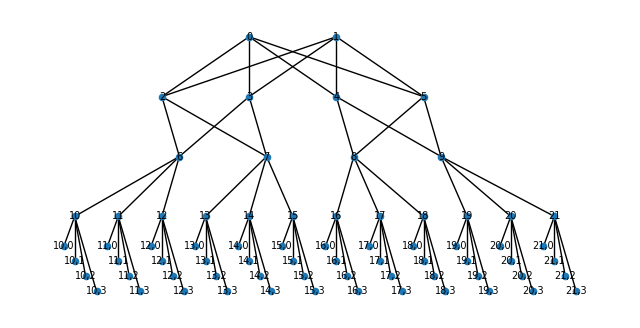

In [76]:
n = 4 # starts from 4
bandwidth = 20
num_ToR = 3
num_qubits_per_node = 4
num_core = n // 2
num_agg = n
num_edge = n**2 // 4
num_nodes = num_edge * num_ToR # number of q nodes
# num_bsms = num_leaves # number of BSMs

# num_bsm = 1
num_bsm_agg = 20
num_bsm_edge = 20
num_pd = 1
num_laser = 1
num_bs = 1
num_es = 1

num_vertices = num_core + num_agg + num_edge + num_nodes
core_bw = 4*bandwidth
agg_bw = 2*bandwidth
edge_bw = bandwidth

G = nx.Graph()
## adding node attributes
# "PD", "BSM", "Laser", "BS", "ES"
attrs = {}

core_switches = range(num_core)
G.add_nodes_from(core_switches, type='core')
for core in core_switches:
    attrs[core] = {"PD": 0, "BSM_ir":0, "BSM_tel":0, "Laser":0, "BS":0, "ES":0}
agg_switches = range(num_core,num_core+num_agg)
G.add_nodes_from(agg_switches, type='agg')
for agg in agg_switches:
    attrs[agg] = {"PD": 0, "BSM_ir":0, "BSM_tel":num_bsm_agg, "Laser":0, "BS":0, "ES":0}
edge_switches = range(num_core+num_agg,num_core + num_agg + num_edge)
G.add_nodes_from(edge_switches, type='edge')
for edge in edge_switches:
    attrs[edge] = {"PD": num_pd, "BSM_ir": num_bsm_edge, "BSM_tel":0, "Laser": num_laser, "BS": num_bs, "ES": num_es}
node_list = range(num_core + num_agg + num_edge,num_vertices)
G.add_nodes_from(node_list, type='node')
node_qubit_list = []
for node in node_list:
    for qubit in range(num_qubits_per_node):
        qname = f"{node},{qubit}"
        node_qubit_list.append(qname)
        G.add_edge(node,qname, weight=1)
        
nx.set_node_attributes(G, attrs)

# G.add_nodes_from(node_qubit_list, type='qubit')

for core in core_switches:
    for agg in agg_switches:
        G.add_edge(core,agg, weight=core_bw)

new_edges = []
extra_edges = []
agg_conn = np.ones(num_agg)* (n//2)
for i, edge in enumerate(edge_switches):
    i1 = np.argwhere(agg_conn>0)[0,0]
    G.add_edge(edge,agg_switches[i1], weight=agg_bw)
    agg_conn[i1] -= 1 
    G.add_edge(edge,agg_switches[i1+1], weight=agg_bw)
    agg_conn[i1+1] -= 1 

for i, edge in enumerate(edge_switches):
    for j in range(num_ToR):
        G.add_edge(edge,node_list[num_ToR*i+j], weight=edge_bw)

shift = 4
# pos_core = {i: (shift+i+ n/4 ,2) for i in core_switches}
# pos_agg = {i: (shift+(i-n//2)% n,1) for i in agg_switches}
# pos_edge = {i: (shift+i-7*n/4+1,0) for i in edge_switches}
# pos_nodes = {node: (shift+i/2-1/4,-1) for i, node in enumerate(node_list)}
pos_core = {i: (8*shift+16*i ,2) for i in core_switches}
pos_agg = {i: (8*shift+16*(((i-n//2)% n)-1),1) for i in agg_switches}
pos_edge = {i: (0*shift+16*(i-1.2*n),0) for i in edge_switches}
pos_nodes = {node: (shift+8*i-n,-1) for i, node in enumerate(node_list)}
pos_qs = {q: (2*i-2,-1.5-(i%4)/4) for i, q in enumerate(node_qubit_list)}
pos = pos_core | pos_agg | pos_edge | pos_nodes | pos_qs


fig, ax = plt.subplots(figsize=(8,4))

nx.draw(G, pos, node_size=20, font_size=7, with_labels=True)
plt.show()

In [7]:
# vertex = "18,1"
# print(G.nodes[vertex])
# print(G.degree[vertex])
# nx.get_node_attributes(G, "BSM")
paths = nx.all_shortest_paths(G, source="10,0", target="13,0")
for path in paths:
    print(path)

['10,0', 10, 6, 2, 7, 13, '13,0']
['10,0', 10, 6, 3, 7, 13, '13,0']


# fat tree

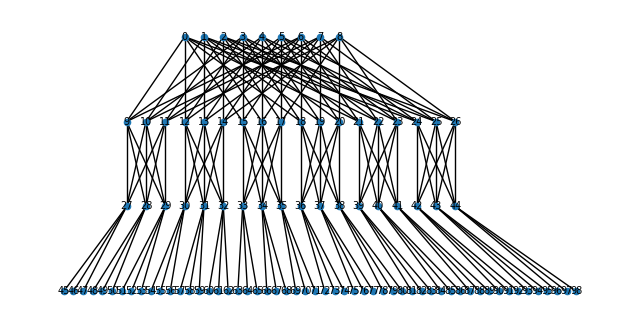

In [2]:
n = 6 # starts from 4
bandwidth = 4
num_bsm = 1
num_core = n**2 // 4
num_agg = n * (n // 2)
num_edge = n * (n // 2)
num_nodes = num_edge * (n // 2) # number of q nodes

core_bw = 4*bandwidth
agg_bw = 2*bandwidth
edge_bw = bandwidth
num_vertices = num_core + num_agg + num_edge + num_nodes

G = nx.Graph()
core_switches = range(num_core)
G.add_nodes_from(core_switches, type='core')
agg_switches = range(num_core,num_core+num_agg)
G.add_nodes_from(agg_switches, type='agg')
edge_switches = range(num_core+num_agg,num_core + num_agg + num_edge)
G.add_nodes_from(edge_switches, type='agg')
node_list = range(num_core + num_agg + num_edge,num_vertices)
G.add_nodes_from(node_list, type='node')


for i_c, core in enumerate(core_switches):
    for i_a, agg in enumerate(agg_switches):
        if i_c % (n//2) == i_a % (n//2) :
            G.add_edge(core,agg, weight=core_bw)

for i_a, agg in enumerate(agg_switches):
    pod = i_a// (n//2)
    for i_e in range(n//2):
        G.add_edge(agg,edge_switches[pod*(n//2)+i_e], weight=agg_bw)

for i, edge in enumerate(edge_switches):
    for j in range(n//2):
        G.add_edge(edge,node_list[(n//2)*i+j], weight=edge_bw)
    

pos_core = {i: (i-n//2 + n**2/4 ,2) for i in core_switches}
pos_agg = {i: ((i-n),1) for i in agg_switches}
pos_edge = {i: ((i-n-(n**2//2)),0) for i in edge_switches}
pos_nodes = {node: (i/2-1/4,-1) for i, node in enumerate(node_list)}
pos = pos_core | pos_agg | pos_edge | pos_nodes


fig, ax = plt.subplots(figsize=(8,4))

nx.draw(G, pos, node_size=20, font_size=7, with_labels=True)
plt.show()

# TOR switch

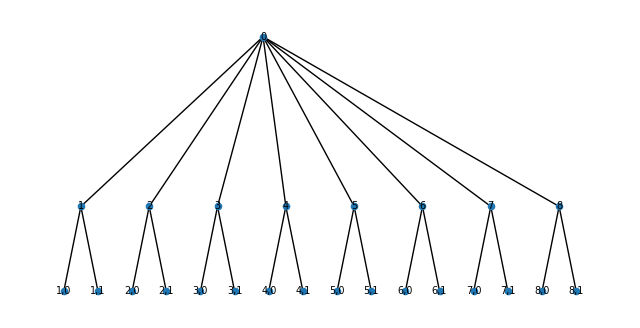

In [5]:
bandwitdth = 1
num_ToR = 8
num_qubits_per_node = 2
num_edge = 1
num_nodes = num_edge * num_ToR # number of q nodes

num_bsm_edge = 2
num_pd = 1
num_laser = 1
num_bs = 1
num_es = 1

num_vertices = num_edge + num_nodes
bandwidth = 1
edge_bw = bandwidth

G = nx.Graph()
## adding node attributes
# "PD", "BSM", "Laser", "BS", "ES"
attrs = {}

edge_switches = range(num_edge)
G.add_nodes_from(edge_switches, type='edge')
for edge in edge_switches:
    attrs[edge] = {"PD": num_pd, "BSM_ir": num_bsm_edge, "BSM_tel":0, "Laser": num_laser, "BS": num_bs, "ES": num_es}
node_list = range(num_edge,num_vertices)
G.add_nodes_from(node_list, type='node')
node_qubit_list = []
for node in node_list:
    for qubit in range(num_qubits_per_node):
        qname = f"{node},{qubit}"
        node_qubit_list.append(qname)
        G.add_edge(node,qname, weight=1)
        
nx.set_node_attributes(G, attrs)

# G.add_nodes_from(node_qubit_list, type='qubit')

for i, edge in enumerate(edge_switches):
    for j in range(num_ToR):
        G.add_edge(edge,node_list[num_ToR*i+j], weight=edge_bw)

shift = 0
pos_edge = {i: (i+ num_ToR/3,0) for i in edge_switches}
pos_nodes = {node: (shift+i,-1) for i, node in enumerate(node_list)}
pos_qs = {q: (i/2-1/4,-1.5) for i, q in enumerate(node_qubit_list)}
pos =  pos_edge | pos_nodes | pos_qs


fig, ax = plt.subplots(figsize=(8,4))

nx.draw(G, pos, node_size=20, font_size=7, with_labels=True)
plt.show()

In [3]:
from network_utils_hybrid import *
import random
import numpy as np

n = 4
num_ToR = 2
specs = {
    "num_sw_ports": n,
    "num_ToR" : num_ToR,
    "qs_per_node" : 10,
    "bandwidth" : 2,
    "num_bsm_ir" : 2,
    "num_bsm_tel" : 2,
    "num_pd" : 1, # inactive
    "num_laser" : 1, # inactive
    "num_bs" : 1, # inactive
    "num_es" : 1 # inactive
}

G, vertex_list = clos_hybrid(specs)
edge_switches, node_list, node_qubit_list = vertex_list
num_nodes = len(node_list)
num_edge = len(edge_switches)
num_qubits_network = len(node_qubit_list)
num_qubits = num_qubits_network

shift = 3.5
pos_core = {i: (3*shift+4*i ,2) for i in core_switches}
pos_agg = {i: (3*shift+4*(((i-n//2)% n)-1),1) for i in agg_switches}
pos_edge = {i: (3*shift+2*i-3.5*n,0) for i in edge_switches}
pos_nodes = {node: (shift+i-n,-1) for i, node in enumerate(node_list)}
pos = pos_core | pos_agg | pos_edge | pos_nodes 

fig, ax = plt.subplots(figsize=(8,4))
nx.draw(G, pos, node_size=20, font_size=7, with_labels=True)
plt.show()


NameError: name 'core_switches' is not defined

In [2]:
num_qubits_network = len(node_qubit_list)
num_qubits = num_qubits_network
num_gates = 10

connections = []
for i in range(num_qubits):
    for j in range(i+1,num_qubits):
        if np.random.rand() > 0.5:
            connections.append((node_qubit_list[i],node_qubit_list[j]))
        else:
            connections.append((node_qubit_list[j],node_qubit_list[i]))
gate_seq_input = random.choices(connections, k=num_gates)


NameError: name 'node_qubit_list' is not defined

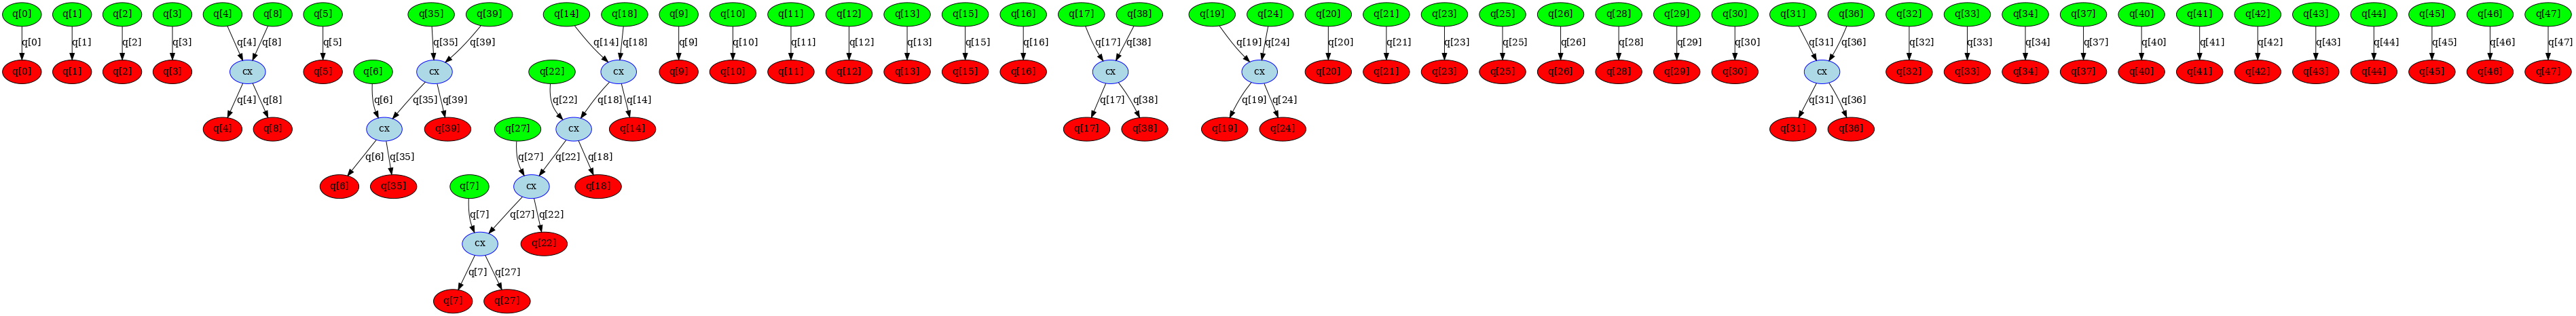

In [78]:
qubit_nx_to_qiskit = {qubit: idx for idx, qubit in enumerate(node_qubit_list)}

qiskit_q_list = QuantumRegister(num_qubits, "q")
circ = QuantumCircuit(qiskit_q_list)

for g in gate_seq_input:
    circ.cx(qubit_nx_to_qiskit[g[0]], qubit_nx_to_qiskit[g[1]])

dag = circuit_to_dag(circ)
dag_drawer(dag)


gate seq: [('11,0', '12,0'), ('13,2', '14,2'), ('18,3', '19,3'), ('15,2', '14,2'), ('18,3', '11,2'), ('15,2', '16,3'), ('17,3', '19,0'), ('16,0', '14,3'), ('19,2', '14,1'), ('16,3', '11,3')]
('13,2', '14,2')
bsm: 7 19


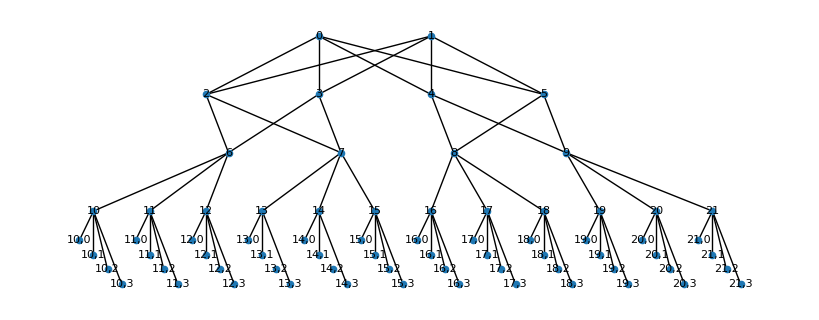

('18,3', '19,3')
bsm: 4 19


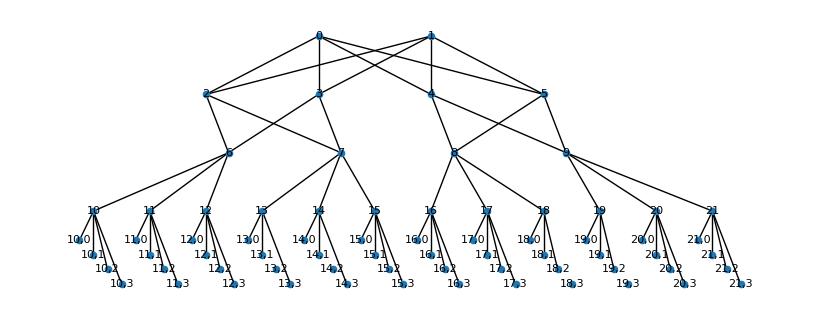

('11,0', '12,0')
bsm: 6 19


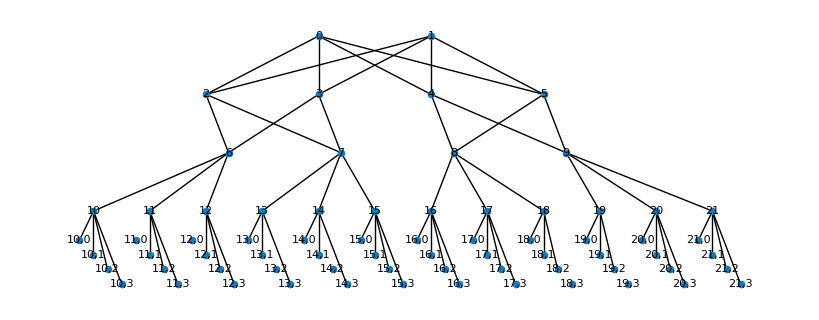

('16,0', '14,3')
bsm: 4 18


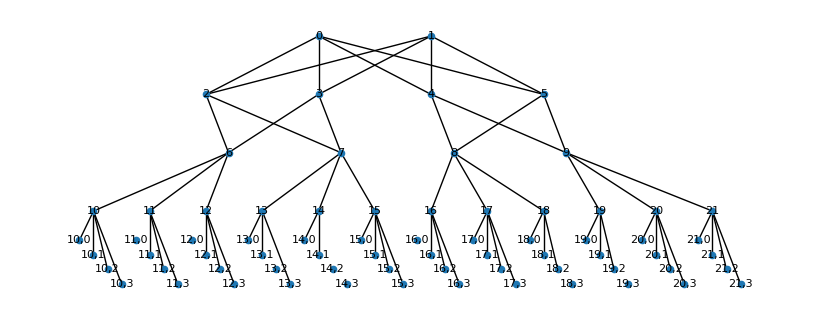

('17,3', '19,0')
bsm: 4 17


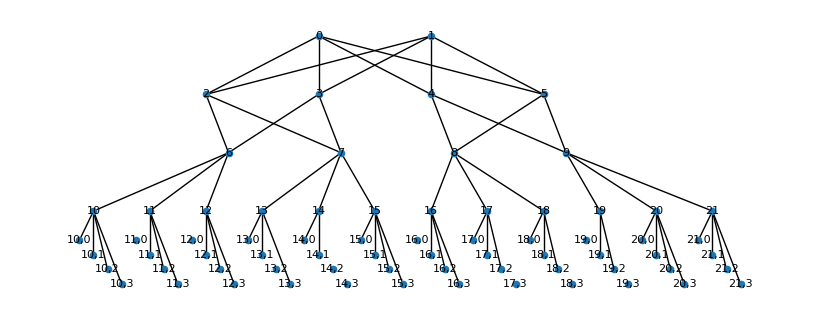

('19,2', '14,1')
bsm: 2 19


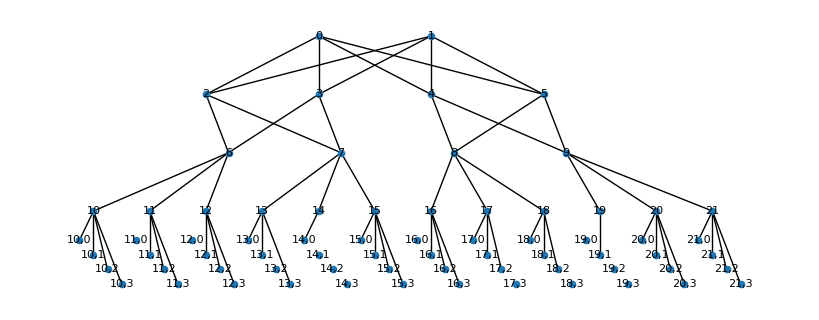

one round!
('15,2', '14,2')
('18,3', '11,2')
one round!
('15,2', '14,2')
bsm: 7 19


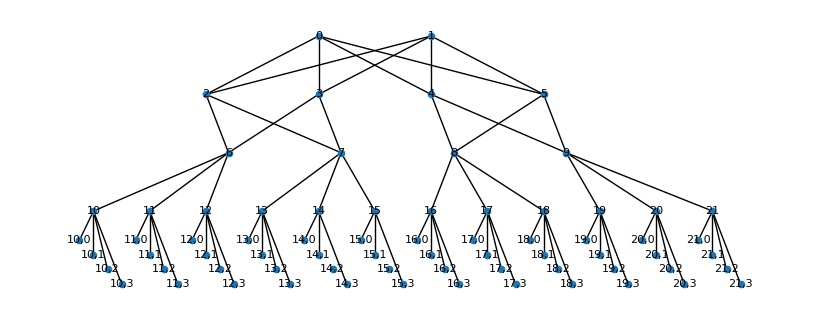

('18,3', '11,2')
bsm: 4 19


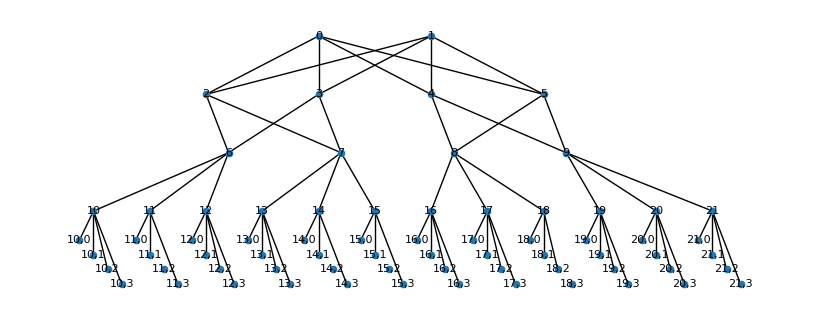

one round!
('15,2', '16,3')
one round!
('15,2', '16,3')
bsm: 4 19


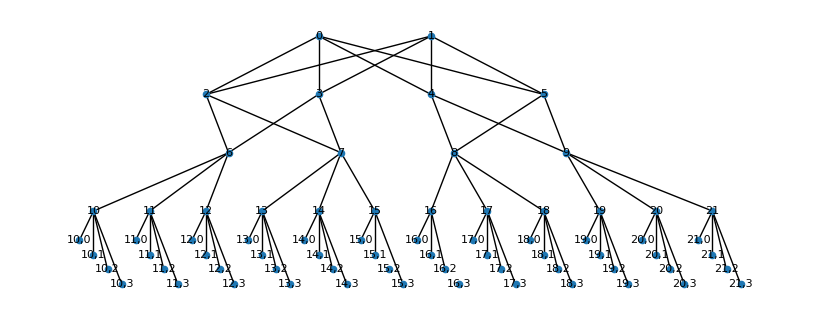

one round!
('16,3', '11,3')
one round!
('16,3', '11,3')
bsm: 4 19


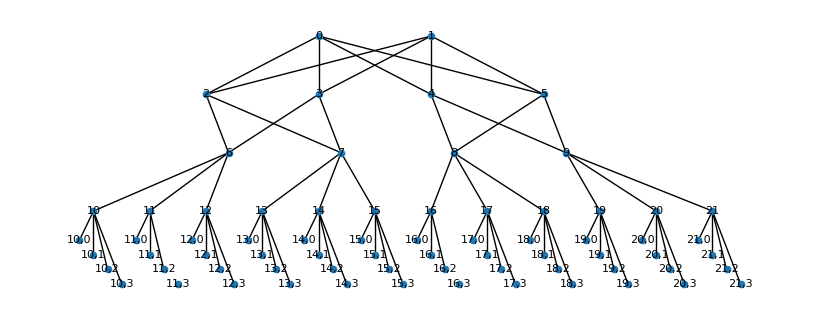

one round!
one round!
num seq: 10 , num switch: 4 , [[2, 4], [1, 1], [0, 1], [0, 1]]


In [80]:
def plotter(G_ins):
    # print(bsm_stat)
    plt.figure(figsize=(8,3))
    nx.draw(G_ins, pos, node_size=20, font_size=8, with_labels=True)
    # nx.draw(G_ins, pos,  with_labels=True)#,  node_color = color_list)
    # nx.draw(G,  with_labels=True, node_color = color_list)
    plt.show()


print("gate seq:", gate_seq_input)

qubit_nx_to_qiskit = {qubit: idx for idx, qubit in enumerate(node_qubit_list)}

qiskit_q_list = QuantumRegister(num_qubits, "q")
circ = QuantumCircuit(qiskit_q_list)

for g in gate_seq_input:
    circ.cx(qubit_nx_to_qiskit[g[0]], qubit_nx_to_qiskit[g[1]])

dag = circuit_to_dag(circ)
dag_drawer(dag)
dag_qubit_map = {bit: index for index, bit in enumerate(dag.qubits)}
switch_seq = []

while len(dag.gate_nodes())>0:

    G_ins =  G.copy()
    execute = True
    while execute:
        execute = False

        indep_gate_seq = []
        dag_node_seq = []
        num_decendants = []
        for node in dag.front_layer():
            if node.op.num_qubits< 2:
                dag.remove_op_node(node)
            if node.op.num_qubits>= 2:
                # gate_set.append((dag_qubit_map[node.qargs[0]],dag_qubit_map[node.qargs[1]]))
                indep_gate_seq.append((node_qubit_list[dag_qubit_map[node.qargs[0]]],node_qubit_list[dag_qubit_map[node.qargs[1]]]))
                dag_node_seq.append(node)
                num_decendants.append(len([g for g in dag.bfs_successors(node)])-1)

        sorted_idx = sorted(range(len(num_decendants)), key=lambda k: num_decendants[k], reverse=True)
        # sorted_idx = sorted(range(len(num_decendants)), key=lambda x: random.random())
        dag_node_seq = [dag_node_seq[k] for k in sorted_idx]
        indep_gate_seq = [indep_gate_seq[k] for k in sorted_idx]

        num_ir_swap = 0
        num_tel_swap = 0

        for i_g, g in enumerate(indep_gate_seq):
            print(g)
            n0 = g[0]
            n1 = g[1]
            if nx.has_path(G_ins,n0,n1):
                paths = nx.all_shortest_paths(G_ins, n0, n1, weight=None)
                for shortestpath in paths:
                    if len(shortestpath)<= 3 :
                        dag.remove_op_node(dag_node_seq[i_g])
                        break
                    elif len(shortestpath)> 5 :
                        tel_ir = "tel"
                    else:
                        tel_ir = "ir"

                    sp = []
                    b = []
                    for i in range(0,len(shortestpath)-1):
                        sp.append((shortestpath[i],shortestpath[i+1]))
                        if 1 < i < len(shortestpath)-2:
                            sw = shortestpath[i]
                            if G_ins.nodes[sw]["BSM_"+tel_ir] > 0:
                                b.append(sw)
                    
                    if len(b)>=1:
                        sw_bsm = random.sample(b,1)[0]
                        G_ins.nodes[sw_bsm]["BSM_"+tel_ir]-= 1
                        for u, v in sp:
                            if G_ins[u][v]['weight'] == 1:
                                G_ins.remove_edge(u, v)
                            else:
                                G_ins[u][v]['weight'] -= 1
                        if  tel_ir == "tel":
                            num_tel_swap += 1
                        else:
                            num_ir_swap += 1
                        
                        dag.remove_op_node(dag_node_seq[i_g])
                        execute = True
                        print("bsm:", sw_bsm, G_ins.nodes[sw_bsm]["BSM_"+tel_ir])
                        plotter(G_ins)

                        break
        print("one round!")  
        if execute:
            switch_num = [num_ir_swap, num_tel_swap]
    switch_seq.append(switch_num)
print("num seq:", len(gate_seq_input), ", num switch:", len(switch_seq), ",",switch_seq)

gate seq: [('13,1', '18,0'), ('12,0', '20,0'), ('12,1', '21,0'), ('10,0', '11,1'), ('11,0', '21,1'), ('14,0', '19,1')]
('13,1', '18,0')
[2, 4]
bsm: 2 1


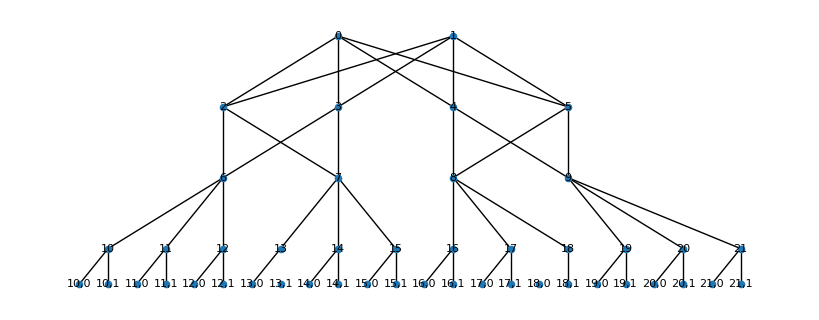

('12,0', '20,0')
[2, 4]
bsm: 4 1


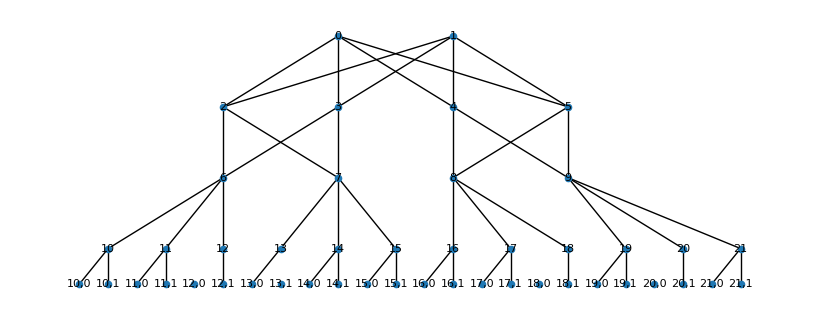

('12,1', '21,0')
[2, 4]
bsm: 4 0


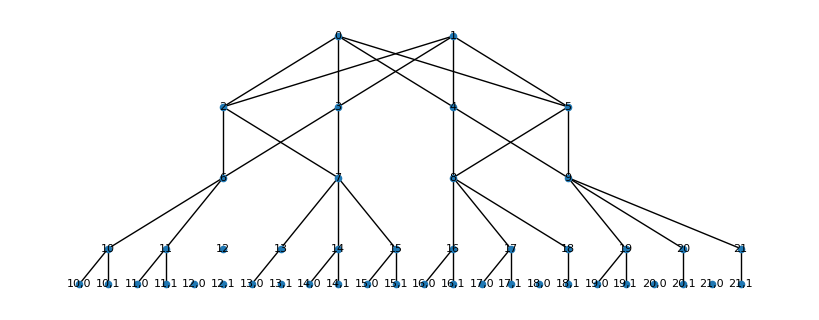

('10,0', '11,1')
[6]
bsm: 6 1


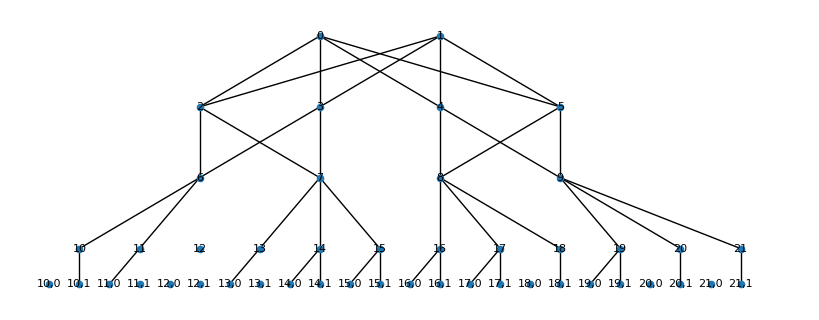

('11,0', '21,1')
[2]
bsm: 2 0


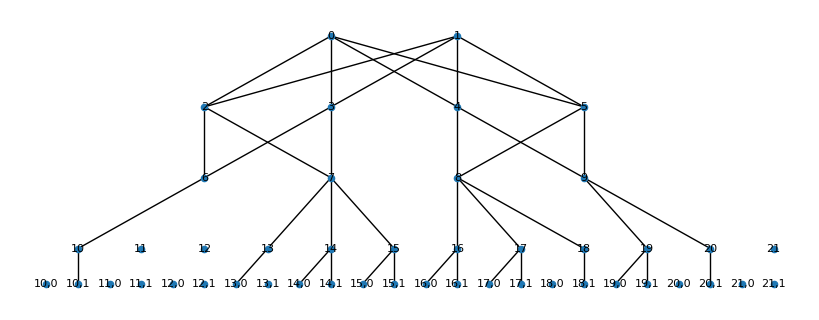

('14,0', '19,1')
[3]
bsm: 3 1


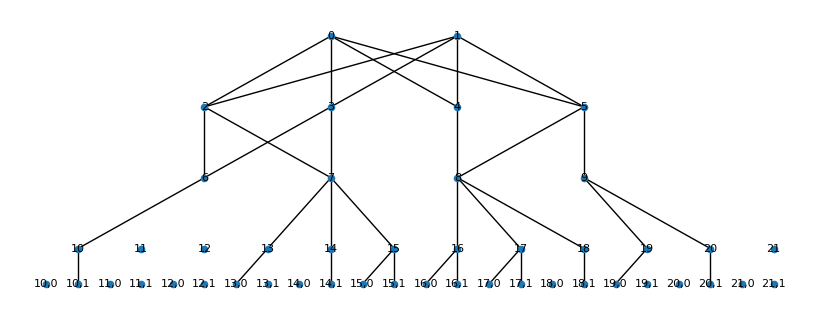

num seq: 6 , num switch: 1 , [[1, 5]]


In [36]:
def plotter(G_ins):
    # print(bsm_stat)
    plt.figure(figsize=(8,3))
    nx.draw(G_ins, pos, node_size=20, font_size=8, with_labels=True)
    # nx.draw(G_ins, pos,  with_labels=True)#,  node_color = color_list)
    # nx.draw(G,  with_labels=True, node_color = color_list)
    plt.show()

num_gates = 1000

# query_seq, gate_mul_seq = parallel_circuit_gen(node_list, num_qubits_per_node, num_gates)

query_seq = [[('13,1', '18,0'), ('12,0', '20,0'), ('12,1', '21,0'), ('10,0', '11,1'), ('11,0', '21,1'), ('14,0', '19,1')]]
# for 
# gate_mul_seq = [[1]*len(query_seq[0])]

# nx.draw(G, pos, node_size=20, font_size=7, with_labels=True)
# plt.show()

# for i_q, gate_seq in enumerate(query_seq):
for i_q in [0]:
    gate_seq = query_seq[i_q]

    gate_seq_iter = gate_seq[:]
    gate_mul_seq_iter = gate_mul_seq[i_q]
    print("gate seq:", gate_seq)
    # print("num links:", num_links)

    switch_time = []

    while len(gate_seq_iter)>0:
        # bsm_stat = np.ones(num_edge,dtype=np.int16)* num_bsm
        num_ir_swap = 0
        num_tel_swap = 0
        G_ins =  G.copy()

        # print(gate_seq_iter)
        inds_keep = []
        for i_g, g in enumerate(gate_seq_iter):
            print(g)#, gate_mul_seq_iter[g]) ###

            # for link in range(gate_mul_seq_iter[g]): ####
            for link in range(1):
                # n0 = int(g[0].split(",")[0])
                # n1 = int(g[1].split(",")[0])
                n0 = g[0]
                n1 = g[1]
                if nx.has_path(G_ins,n0,n1):
                    # shortestpath = nx.shortest_path(G_ins,n0,n1,weight=None)
                    paths = nx.all_shortest_paths(G_ins, n0, n1, weight=None)
                    path_found = False
                    for shortestpath in paths:
                        tel_ir = "ir"
                        if len(shortestpath)> 5 :
                            tel_ir = "tel"

                        sp = []
                        b = []
                        for i in range(0,len(shortestpath)-1):
                            sp.append((shortestpath[i],shortestpath[i+1]))
                            if 1 < i < len(shortestpath)-2:
                                sw = shortestpath[i]
                                # print(sw)
                                if G_ins.nodes[sw]["BSM_"+tel_ir] > 0:
                                    b.append(sw)
                        
                        if len(b)>=1:
                            print(b)
                            sw_bsm = random.sample(b,1)[0]
                            G_ins.nodes[sw_bsm]["BSM_"+tel_ir]-= 1
                            for u, v in sp:
                                if G_ins[u][v]['weight'] == 1:
                                    G_ins.remove_edge(u, v)
                                else:
                                    G_ins[u][v]['weight'] -= 1
                            if  tel_ir == "tel":
                                num_tel_swap += 1
                            else:
                                num_ir_swap += 1
                            
                            print("bsm:", sw_bsm, G_ins.nodes[sw_bsm]["BSM_"+tel_ir])
                            plotter(G_ins)
                            path_found = True
                            break
        
                    if not path_found:
                        inds_keep.append(i_g)
                        # gate_mul_seq_iter[g] -= link ####
                        break
                    #     assert 0
                    # # # print(bsm_stat)
                    # print(bsm_stat)
                    # plt.figure(figsize=(8,3))
                    # nx.draw(G_ins, pos,  with_labels=True)#,  node_color = color_list)
                    # # nx.draw(G,  with_labels=True, node_color = color_list)
                    # plt.show()
                else:
                    inds_keep.append(i_g)
                    # gate_mul_seq_iter[g] -= link ####
                    break

        switch_time.append([num_ir_swap, num_tel_swap])
        # print(bsm_stat)
        # plt.figure(figsize=(8,3))
        # nx.draw(G_ins, pos,  with_labels=True)#,  node_color = color_list)
        # # nx.draw(G,  with_labels=True, node_color = color_list)
        # plt.show()

        gate_seq_iter = [gate_seq_iter[idx] for idx in inds_keep]
        # gate_mul_seq_iter = {g:gate_mul_seq_iter[g] for g in gate_seq_iter} ###

    print("num seq:", len(gate_seq), ", num switch:", len(switch_time), ",",switch_time)

out of all shortest paths available to run the ebit protocol, we should choose one at random. the code right now runs in order.

better solution is a ILP formulation of the flow.

In [51]:
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))

Nmax =  int(1e6)
switch_time = [1,5,3,10]
p = 0.1
latency = np.zeros(len(switch_time))
for i_N, Nlinks in enumerate(switch_time):
    Ns = np.zeros((Nlinks, Nmax))
    for i in range(Nlinks):
        Ns[i,:] = F_geo(np.random.uniform(low=p, high=1, size=(Nmax,)),p)

    # print(np.max(Ns,axis=0).shape)
    latency[i_N] = np.mean(np.max(Ns,axis=0))

print(latency)


[10.003956 22.180585 17.89486  28.299728]


In [53]:
sum([4,3])

7

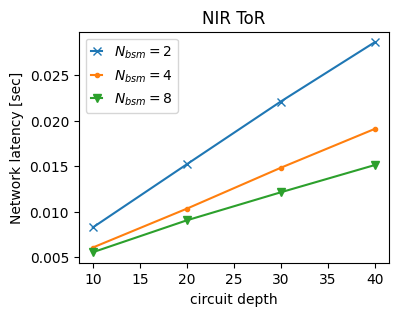

In [3]:
plt.figure(figsize=(4,3))
# bsm = 2
num_gates_list = np.arange(10,41,10)
T_tel_10 = [0.08520000000000003, 0.16788000000000008, 0.2502199999999999, 0.3315399999999997]
T_nir_10 = [0.008275876584979998, 0.015219673198780004, 0.022120536359889992, 0.028644778532000002]
# plt.plot(num_gates_list, T_tel_10,"x-", label=r"$N_{bsm}=2$")
plt.plot(num_gates_list, T_nir_10,"x-", label=r"$N_{bsm}=2$")

# bsm = 4
# Ntor = 40
T_tel_40 = [0.0630400000000001, 0.11930666666666674, 0.17499333333333328, 0.23021, 0.2872983333333335, 0.34299833333333324, 0.39884499999999984, 0.45484, 0.5109549999999999, 0.5664683333333336] 
T_nir_40 = [0.005321750560510002, 0.00900155679877, 0.012497352839020003, 0.015820196824640004, 0.019438950297830004, 0.022915131507149994, 0.026224399422170013, 0.02972329759683, 0.03324319078348001, 0.03649973580919001]
num_gates_list = np.arange(10,101,10)
# plt.plot(num_gates_list, T_tel_40,".-", label="Telecom")
# plt.plot(num_gates_list, T_nir_40,".-", label="NIR")

num_gates_list = np.arange(10,41,10)
# Ntor = 20
T_tel_20 =[0.06498666666666673, 0.11971833333333348, 0.17705333333333337, 0.23476499999999986]
T_nir_20 = [0.005915473933899998, 0.009322454058870002, 0.013072373964459993, 0.016984402070149993]
# plt.plot(num_gates_list, T_tel_20,".-", label="Telecom")
# plt.plot(num_gates_list, T_nir_20,".-", label="NIR")
# Ntor = 10
T_tel_10 = [0.06507833333333335, 0.12400666666666682, 0.18402166666666672, 0.24311666666666665]
T_nir_10 = [0.006064816444540001, 0.010335618785639999, 0.014835071062269995, 0.019107469957089993]
# plt.plot(num_gates_list, T_tel_10,".-", label=r"$N_{bsm}=4$")
plt.plot(num_gates_list, T_nir_10,".-", label=r"$N_{bsm}=4$")

# bsm = 8
T_tel_10 = [0.0577864285714286, 0.10484154761904761, 0.14979821428571433, 0.19308821428571438]
T_nir_10 = [0.005546528576519999, 0.00905524381885, 0.01213706445684, 0.015132912963979997]
# plt.plot(num_gates_list, T_tel_10,"v-", label=r"$N_{bsm}=8$")
plt.plot(num_gates_list, T_nir_10,"v-", label=r"$N_{bsm}=8$")

plt.title("NIR ToR")
plt.legend(handlelength=0.8)
plt.xlabel("circuit depth")
plt.ylabel("Network latency [sec]")
# plt.yscale("log")
# plt.ylim([0,0.03])
plt.show()

In [22]:
from network_utils_hybrid import *
import random
import numpy as np
import time

Nrep = 100
num_gates_list = np.arange(10,41,10)
num_ToR = 10

specs = {
    "num_ToR" : num_ToR,
    "qs_per_node" : 10,
    "bandwidth" : 8,
    "num_bsm_ir" : 2,
    "num_pd" : 1, # inactive
    "num_laser" : 1, # inactive
    "num_bs" : 1, # inactive
    "num_es" : 1 # inactive
}

telecom_gen_rate = 1/(1e-2) # ebit average generation time in sec
switch_duration = 1e-3 # average switching delay in sec
nir_prob = 1e-2 # NIR gen prob
qubit_reset = 1e-6 # qubit reset time in sec

T_tel_list = []
T_nir_list = []
# print(problem_size)
num_gates = 100

num_bsm_list = np.arange(2,17,2)
for num_bsm in num_bsm_list:
    specs["num_bsm_ir"] = num_bsm
    G, vertex_list = tor_switch(specs)
    edge_switches, node_list, node_qubit_list  = vertex_list


    tic = time.time()
    print(num_gates)
    T_tel = []
    T_nir = []
    for _ in range(Nrep):
        query_seq, gate_mul_seq = parallel_circuit_gen(node_list, specs["qs_per_node"], num_gates)
        switch_seq = network_latency_multiqubit_hybrid(G, vertex_list, query_seq, gate_mul_seq)

        tel_latency = []
        nir_latency = []
        for switch_time in switch_seq:
            tel_latency.append(1/telecom_gen_rate * time_spdc(np.array(switch_time)).sum() + switch_duration*len(switch_time))
            # nir_latency.append(qubit_reset * time_nir(switch_time, nir_prob).sum() + switch_duration*len(switch_time))

        T_tel.append(sum(tel_latency) + switch_duration * len(switch_seq))
        # T_nir.append(sum(nir_latency) + switch_duration * len(switch_seq))

    T_tel_list.append(sum(T_tel)/len(T_tel))
    # T_nir_list.append(sum(T_nir)/len(T_nir))
    toc = time.time()
    print(f"elapsed time {toc-tic} sec")

print(T_tel_list)
# print(T_nir_list)


100
elapsed time 6.926065921783447 sec
100
elapsed time 3.938966751098633 sec
100
elapsed time 2.908961772918701 sec
100
elapsed time 2.410125255584717 sec
100
elapsed time 2.1912283897399902 sec
100
elapsed time 1.942908525466919 sec
100
elapsed time 1.8185203075408936 sec
100
elapsed time 1.7282524108886719 sec
[0.8231199999999997, 0.5872016666666667, 0.4780666666666664, 0.4173709523809525, 0.3747326190476192, 0.34347280303030303, 0.3258492488067488, 0.310932717005217]


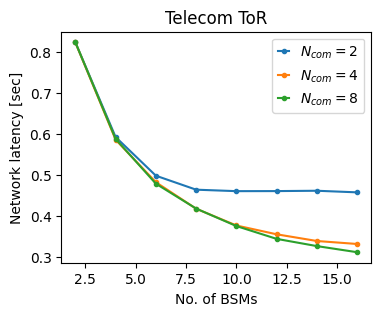

In [24]:
plt.figure(figsize=(4,3))

num_bsm_list = np.arange(2,17,2)
T_tel_2 = [0.8226699999999997, 0.5918016666666667, 0.4975383333333335, 0.4634616666666666, 0.4598805555555557, 0.4600275793650793, 0.46085730158730165, 0.45693626984126956]
plt.plot(num_bsm_list, T_tel_2,".-", label=r"$N_{com}=2$")

T_tel_4 = [0.8225799999999999, 0.585225, 0.4816649999999999, 0.4170154761904762, 0.37612726190476203, 0.35464629148629145, 0.3382952375402376, 0.331023730991231]
plt.plot(num_bsm_list, T_tel_4,".-", label=r"$N_{com}=4$")

T_tel_8 = [0.8231199999999997, 0.5872016666666667, 0.4780666666666664, 0.4173709523809525, 0.3747326190476192, 0.34347280303030303, 0.3258492488067488, 0.310932717005217]
plt.plot(num_bsm_list, T_tel_8,".-", label=r"$N_{com}=8$")

plt.title("Telecom ToR")
plt.legend(handlelength=0.8)
plt.xlabel("No. of BSMs")
plt.ylabel("Network latency [sec]")
# plt.yscale("log")
# plt.ylim([0,0.03])
plt.show()